In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)  # this is needed since the combined df has ~400 cols

In [199]:
train = pd.read_csv('./Data/train_lonlat_id_CS_0521_feature.csv')
test = pd.read_csv('./Data/test_lonlat_id_CS_0521_feature.csv')
macro = pd.read_csv('./Data/macro_feature_CS_0521.csv')
id_test = test.id
try:
    f_imp = pd.read_csv('./feature_importance.csv')
except:
    pass

In [162]:
# y_train = np.log1p(train["price_doc"]) # log1p transformation may hurt performance
y_train = train['unit_price']
y_train.loc[y_train.isnull()]=y_train.median()

x_train = train.drop(["id", "price_doc","unit_price","log_price_doc","full_sq"], axis=1)
x_test = test.drop(["id","price_doc","unit_price","log_price_doc","full_sq"], axis=1)


In [163]:
print x_train.shape
print x_test.shape

(30471, 318)
(7662, 318)


In [164]:
num_train = len(train)
df_all = pd.concat([x_train,x_test])

In [165]:
# change ID variable to categorical variables
IDs = ['ID_big_road1','ID_big_road2',
        'ID_bus_terminal','ID_metro',
       'ID_railroad_station_avto',
       'ID_railroad_station_walk',
       'ID_railroad_terminal']

# def to_object(ID,df):
#     df[ID] = df[ID].astype(object)
#     return(df)

# df_all=to_object(IDs,df_all)

df_all = df_all.drop(IDs, axis=1)

In [166]:
matchers = ['1000','1500','2000','2500','3000','3500','4000','4500','5000']
matching = [s for s in df_all.columns.tolist() if any(xs in s for xs in matchers)]
df_all = df_all.drop(matching, axis=1)

In [167]:
matchers = ['raion']
matching = [s for s in df_all.columns.tolist() if any(xs in s for xs in matchers)]
# matching
df_all = df_all.drop(matching, axis=1)

In [168]:
matchers = ['male','female']
matching = [s for s in df_all.columns.tolist() if any(xs in s for xs in matchers)]
# matching
df_all = df_all.drop(matching, axis=1)

In [169]:
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_all[c].values)) 
        df_all[c] = lbl.transform(list(df_all[c].values))

In [170]:
df_all=df_all.drop(['timestamp'],axis =1 )

In [171]:
x_train = df_all.iloc[:num_train,:]
x_test = df_all.iloc[num_train:,:]

print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('y_train shape',y_train.shape)

('x_train shape', (30471, 151))
('x_test shape', (7662, 151))
('y_train shape', (30471,))


In [178]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[0]	train-rmse:137192	test-rmse:137205
[50]	train-rmse:40417.2	test-rmse:42223.3
[100]	train-rmse:36964.8	test-rmse:40306.3
[150]	train-rmse:35530.2	test-rmse:40024.9
[200]	train-rmse:34335.5	test-rmse:39891.6
[250]	train-rmse:33280.3	test-rmse:39809.4
[300]	train-rmse:32360.6	test-rmse:39779.4
[350]	train-rmse:31486	test-rmse:39765.4
CPU times: user 2min 46s, sys: 6.49 s, total: 2min 52s
Wall time: 28.5 s


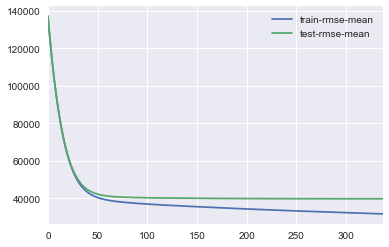

In [179]:
%%time
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [180]:
%%time
num_boost_rounds = len(cv_output)
print(num_boost_rounds)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

338
CPU times: user 1min 14s, sys: 1.74 s, total: 1min 16s
Wall time: 11.8 s


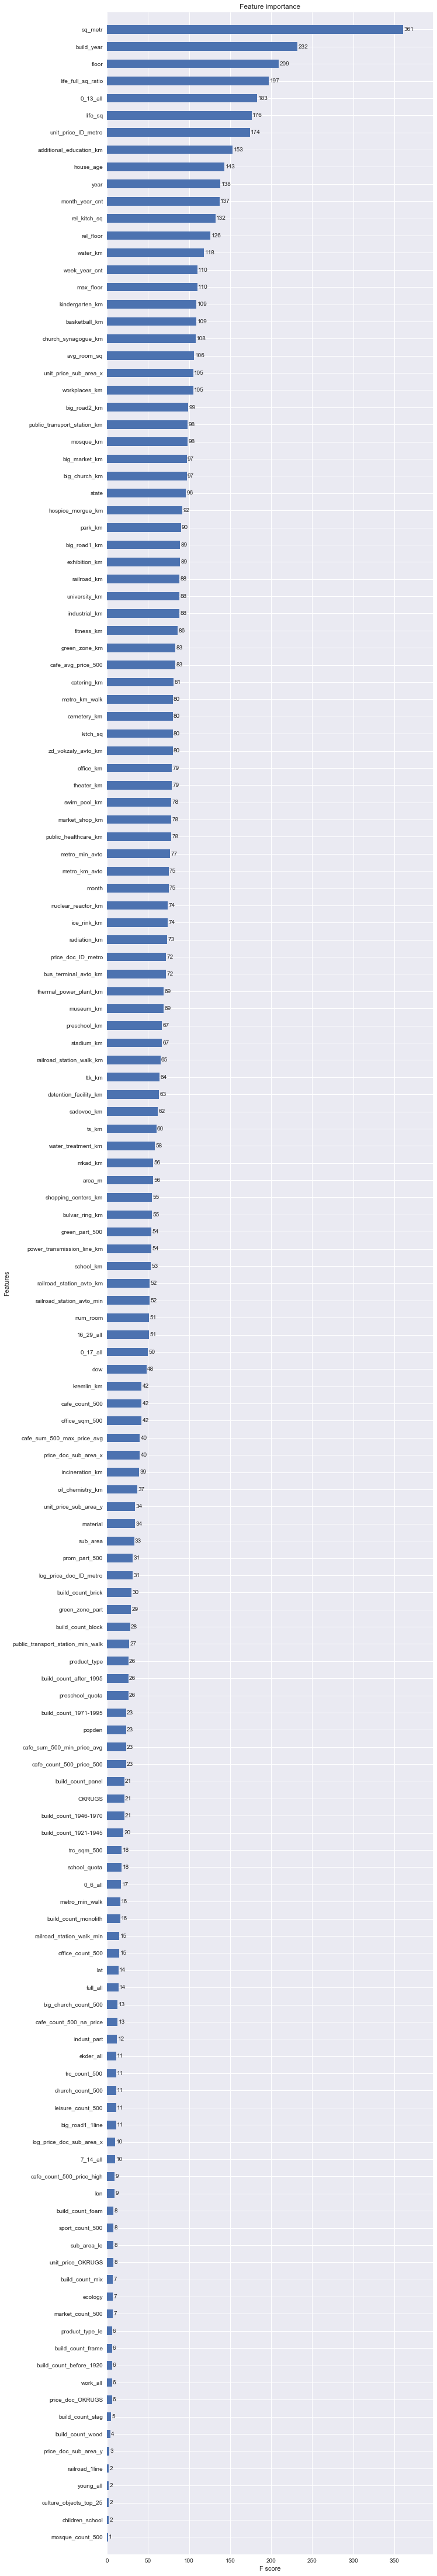

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(10, 80))
xgb.plot_importance(model,\
#                     max_num_features=50, \
                    height=0.5, ax=ax)

In [182]:
importance = model.get_fscore()
importance = pd.DataFrame(sorted(importance.items()),columns =['feature','fscore'])
importance = importance.sort_values(by='fscore',ascending=False).reset_index(drop=True)
importance_features = list(importance.loc[:,'feature'])
importance_features


['sq_metr',
 'build_year',
 'floor',
 'life_full_sq_ratio',
 '0_13_all',
 'life_sq',
 'unit_price_ID_metro',
 'additional_education_km',
 'house_age',
 'year',
 'month_year_cnt',
 'rel_kitch_sq',
 'rel_floor',
 'water_km',
 'week_year_cnt',
 'max_floor',
 'kindergarten_km',
 'basketball_km',
 'church_synagogue_km',
 'avg_room_sq',
 'unit_price_sub_area_x',
 'workplaces_km',
 'big_road2_km',
 'public_transport_station_km',
 'mosque_km',
 'big_market_km',
 'big_church_km',
 'state',
 'hospice_morgue_km',
 'park_km',
 'big_road1_km',
 'exhibition_km',
 'railroad_km',
 'industrial_km',
 'university_km',
 'fitness_km',
 'cafe_avg_price_500',
 'green_zone_km',
 'catering_km',
 'kitch_sq',
 'metro_km_walk',
 'zd_vokzaly_avto_km',
 'cemetery_km',
 'office_km',
 'theater_km',
 'public_healthcare_km',
 'swim_pool_km',
 'market_shop_km',
 'metro_min_avto',
 'month',
 'metro_km_avto',
 'ice_rink_km',
 'nuclear_reactor_km',
 'radiation_km',
 'price_doc_ID_metro',
 'bus_terminal_avto_km',
 'museum_k

In [194]:
test.loc[test.sq_metr.isnull(),'sq_metr'] = test.sq_metr.median()
test.loc[test.sq_metr.isnull(),'sq_metr']

Series([], Name: sq_metr, dtype: float64)

In [195]:
# y_predict = model.predict(dtest)
y_predict = model.predict(dtest)*test.sq_metr
# y_predict = np.exp(y_predict) - 1
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
df_sub.to_csv('./sub.csv', index=False)


In [196]:
importance.to_csv('./feature_importance.csv')

## Select top N features

In [156]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
rmse_result_dict={}

In [204]:
f_imp.feature[:100]

0                               sq_metr
1                            build_year
2                                 floor
3                    life_full_sq_ratio
4                              0_13_all
5                               life_sq
6                   unit_price_ID_metro
7               additional_education_km
8                             house_age
9                                  year
10                       month_year_cnt
11                         rel_kitch_sq
12                            rel_floor
13                             water_km
14                        week_year_cnt
15                            max_floor
16                      kindergarten_km
17                        basketball_km
18                  church_synagogue_km
19                          avg_room_sq
20                unit_price_sub_area_x
21                        workplaces_km
22                         big_road2_km
23          public_transport_station_km
24                            mosque_km


In [160]:
for i in [95]:
    # create subset of df_all
    df_all_subset = df_all.loc[:,importance_features[:i]]
#     prepare data
    x_train_subset = df_all_subset.iloc[:num_train,:]
    dtrain_subset = xgb.DMatrix(x_train_subset, y_train)
#     Train model / Cross validation 
    cv_output = xgb.cv(xgb_params, dtrain_subset, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
    print('finish',i)
#     save result
    rmse_result_dict[i]=cv_output.iloc[-1,:]
    

[0]	train-rmse:8.2065e+06	test-rmse:8.21161e+06
[50]	train-rmse:2.53974e+06	test-rmse:2.89098e+06
[100]	train-rmse:2.20286e+06	test-rmse:2.70089e+06
[150]	train-rmse:2.07411e+06	test-rmse:2.65747e+06
[200]	train-rmse:1.98022e+06	test-rmse:2.63322e+06
[250]	train-rmse:1.90464e+06	test-rmse:2.62288e+06
[300]	train-rmse:1.84187e+06	test-rmse:2.61501e+06
[350]	train-rmse:1.78237e+06	test-rmse:2.60802e+06
[400]	train-rmse:1.73008e+06	test-rmse:2.605e+06
[450]	train-rmse:1.68586e+06	test-rmse:2.60207e+06
[500]	train-rmse:1.64236e+06	test-rmse:2.59955e+06
('finish', 95)


In [158]:
test_rmse_mean=[]
top_n_features=[]
for i in range(80,111,5):
    top_n_features.append(i)
    test_rmse_mean.append(rmse_result_dict[i]['test-rmse-mean'])

    

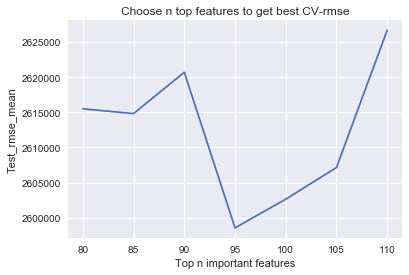

In [159]:
# rmse=pd.DataFrame(zip(top_n_features,(x/10**3 for x in test_rmse_mean)),columns=['Top_n_features','test_rmse_mean'])
rmse=pd.DataFrame(zip(top_n_features,test_rmse_mean),columns=['Top_n_features','test_rmse_mean'])
fig, ax = plt.subplots()
plt.plot(rmse.Top_n_features,rmse.test_rmse_mean)
ax.set(xlabel='Top n important features',
       ylabel='Test_rmse_mean',
       title = 'Choose n top features to get best CV-rmse')

plt.show()

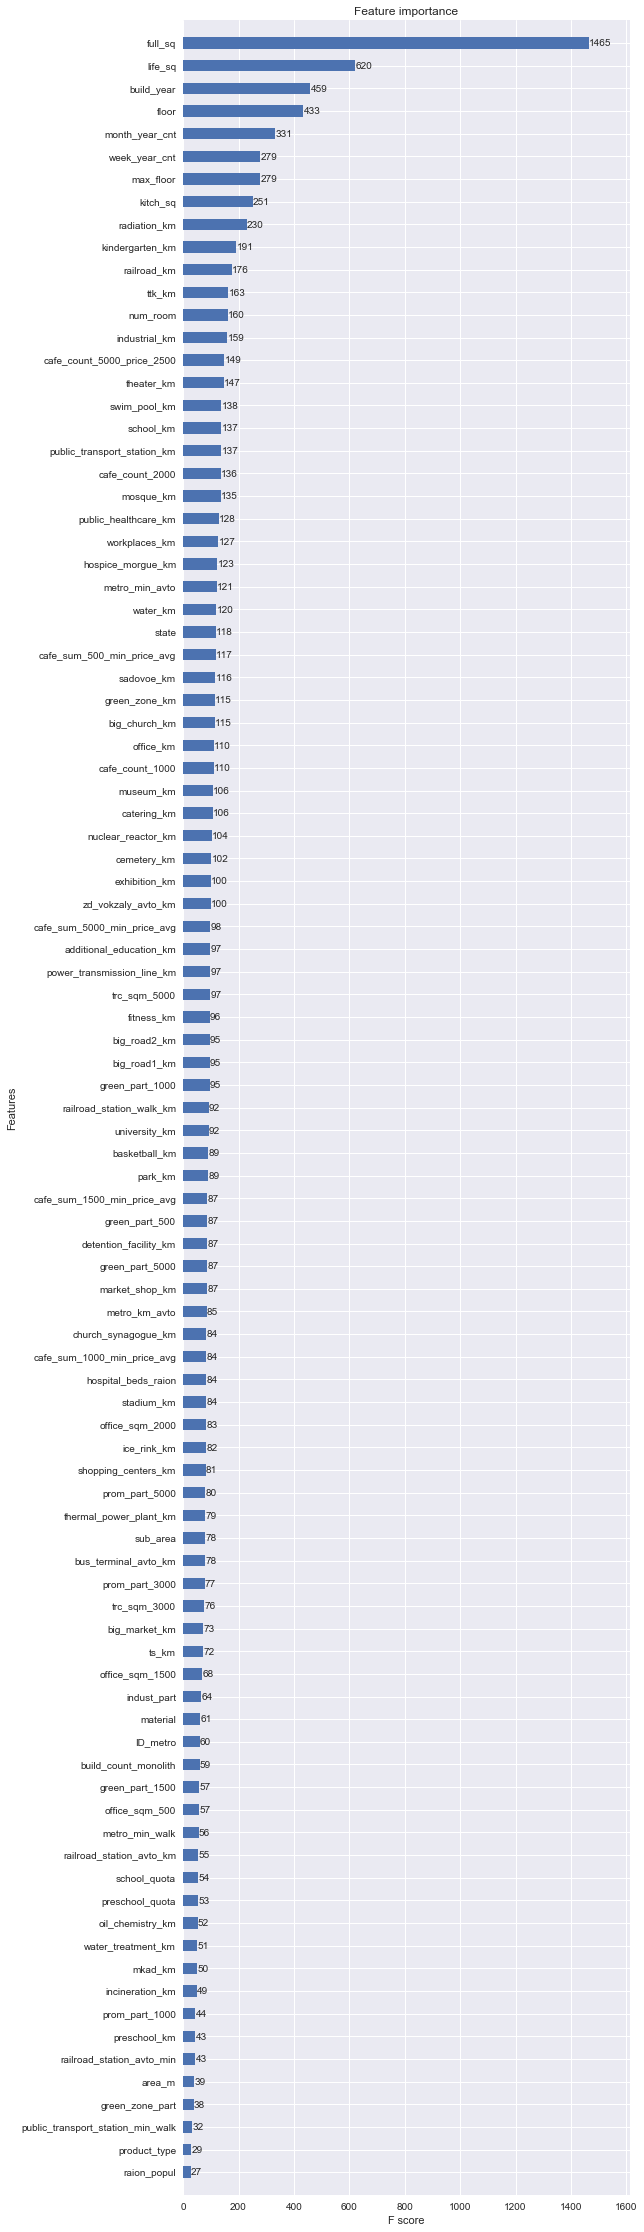

In [165]:
num_boost_round = model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain_subset, num_boost_round=num_boost_round)
fig, ax = plt.subplots(1, 1, figsize=(8, 40))
xgb.plot_importance(model, max_num_features=200, height=0.5, ax=ax)
plt.show()


In [167]:
x_test_subset = df_all_subset.iloc[num_train:,:]
dtest_subset = xgb.DMatrix(x_test_subset)

y_pred = model.predict(dtest_subset)
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
df_sub.to_csv('./sub.csv', index=False)